#  <font color='#FFE15D'><b>💎 Data</b></font>

# 🔴 **Import**

In [4]:
import os
import re
import time
import json
import random
import string
import psutil
import pickle
from tqdm import tqdm
from pprint import pprint
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode

from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers, pre_tokenizers, normalizers, decoders, processors
import tiktoken

import torch
from torch.utils.data import TensorDataset, Dataset, IterableDataset, DataLoader

/opt/anaconda3/envs/deep/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/opt/anaconda3/envs/deep/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/anaconda3/envs/deep/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/anaconda

# 🔴 **Environment Setup**

## 🟠 `pip`

In [1]:
!pip install datasets

In [2]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tiktoken]


# 🔴 **Utils**

In [5]:
def get_sample(dataset):
    # Randomly select an index from the training dataset
    idx = random.randint(0, len(dataset['train']))

    # Return the "text" field of the randomly selected training sample
    return dataset['train'][idx]['text']

# 🔴 **EDA**

## 🟠 Exploring the Dataset

In [7]:
dataset = load_dataset("roneneldan/TinyStories")

Generating validation split: 100%|██████████| 21990/21990 [00:00<00:00, 992005.95 examples/s]


In [9]:
sample = get_sample(dataset)
print(sample)

Once upon a time there was a special gem. It was sparkly and beautiful. Everyone wanted to own it, but nobody could.

One day a creative bird came along. He had a plan to get the jewel. He held onto it as he flew, high in the sky.

Suddenly, he had an idea. He opened his wings wide and released the gem into the air. It sparkled and glowed as it flew all around. Everyone was so happy! Now they could admire the joy.

The bird flew away, happy that he had helped. The people watched, amazed at what they had seen. They had all enjoyed the pretty jewel.

The end.


## 🟠 Measuring RAM Usage After Loading Dataset

In [ ]:
# RAM before
process = psutil.Process(os.getpid())
ram_before = process.memory_info().rss  # in bytes

# Load dataset
dataset = load_dataset("roneneldan/TinyStories")

# RAM after
ram_after = process.memory_info().rss

# Result
ram_used = ram_after - ram_before
print(f"🔹 RAM used for loading dataset: {ram_used / (1024**2):.2f} MB")


In [ ]:
# RAM before
process = psutil.Process(os.getpid())
ram_before = process.memory_info().rss  # in bytes

# Load full dataset into memory
train = list(dataset["train"])
val = list(dataset["validation"])

# RAM after
ram_after = process.memory_info().rss

# Result
ram_used = ram_after - ram_before
print(f"🔹 RAM used for loading full dataset into memory: {ram_used / (1024**3):.2f} GB")


In [ ]:
# RAM before
process = psutil.Process(os.getpid())
ram_before = process.memory_info().rss  # in bytes

for item in tqdm(dataset["train"], desc="Looping over the dataset {Train}"):
    pass

for item in tqdm(dataset["validation"], desc="Looping over the dataset {Valid}"):
    pass

# RAM after
ram_after = process.memory_info().rss

# Result
ram_used = ram_after - ram_before
print(f"\n🔹 RAM usage while looping over the dataset: {ram_used / (1024**3):.2f} GB")


## 🟠 Measuring RAM Usage After Tokenization

In [10]:
# Load tiktoken encoder (GPT-3.5/GPT-4 encoding)
tokenizer = tiktoken.get_encoding("gpt2")  # 'gpt2' for GPT-Neo compatibility

In [11]:
# Tokenization {train}
tokenized_train_samples = []
for item in tqdm(dataset["train"], desc="Tokenizing Train Set"):
    input_ids = tokenizer.encode(item["text"])
    tokenized_train_samples.append(np.array(input_ids))

# Total token count and estimated memory (GB)
total_train_tokens = sum(len(toks) for toks in tokenized_train_samples)
bytes_per_token = 4  # int32:4 | uint16:2
total_size_gb = total_train_tokens * bytes_per_token / (1024**3)

print(f"\n🔹 Total tokens in train dataset: {total_train_tokens:,}")
print(f"🔹 Estimated train token memory: {total_size_gb:.2f} GB")

Tokenizing Train Set: 100%|██████████| 2119719/2119719 [07:04<00:00, 4991.75it/s]



🔹 Total tokens in train dataset: 471,872,517
🔹 Estimated train token memory: 1.76 GB


In [12]:
# Tokenization {validation}
tokenized_valid_samples = []
for item in tqdm(dataset["validation"], desc="Tokenizing Validation Set"):
    input_ids = tokenizer.encode(item["text"])
    tokenized_valid_samples.append(np.array(input_ids))

# Total token count and estimated memory (MB)
total_valid_tokens = sum(len(toks) for toks in tokenized_valid_samples)
total_size_mb = total_valid_tokens * bytes_per_token / (1024**2)

print(f"\n🔹 Total tokens in validation dataset: {total_valid_tokens:,}")
print(f"🔹 Estimated validation token memory: {total_size_mb:.2f} MB")


Tokenizing Validation Set: 100%|██████████| 21990/21990 [00:04<00:00, 5404.89it/s]


🔹 Total tokens in validation dataset: 4,743,928
🔹 Estimated validation token memory: 18.10 MB


### 🟡 Save the tokens for future use

In [13]:
# Save tokens as a pickle file
with open('tokenized_train_samples.pkl', 'wb') as f:
    pickle.dump(tokenized_train_samples, f)

with open('tokenized_valid_samples.pkl', 'wb') as f:
    pickle.dump(tokenized_valid_samples, f)

In [14]:
# RAM before
process = psutil.Process(os.getpid())
ram_before = process.memory_info().rss  # in bytes

# Load data from the pickle file
with open('tokenized_train_samples.pkl', 'rb') as f:
    tokenized_train_samples = pickle.load(f)

with open('tokenized_valid_samples.pkl', 'rb') as f:
    tokenized_valid_samples = pickle.load(f)

# RAM after
ram_after = process.memory_info().rss

# Result
ram_used = ram_after - ram_before
print(f"🔹 RAM used for loading full dataset into memory: {ram_used / (1024**3):.2f} GB")

🔹 RAM used for loading full dataset into memory: 2.31 GB


In [15]:
train_bytes = sum(arr.nbytes for arr in tokenized_train_samples)
valid_bytes = sum(arr.nbytes for arr in tokenized_valid_samples)

print(f"🔹 Train data size (bytes): {train_bytes / 1024 ** 3:.2f} GB")
print(f"🔹 Valid data size (bytes): {valid_bytes / 1024 ** 2:.2f} MB")

🔹 Train data size (bytes): 3.52 GB
🔹 Valid data size (bytes): 36.19 MB


## 🟠 Distribution of Token Counts per Story

In [16]:
# Counting Tokens per sample
token_counts = []
for tokens in tqdm(tokenized_train_samples, desc="Counting Tokens per sample"):
    token_counts.append(len(tokens))

Counting Tokens per sample: 100%|██████████| 2119719/2119719 [00:00<00:00, 3725379.94it/s]


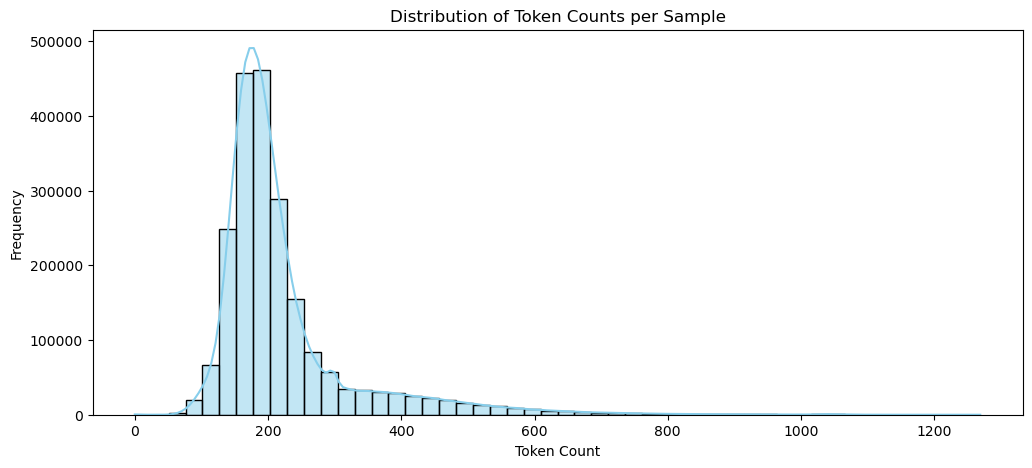

In [18]:
plt.figure(figsize=(12, 5))
sns.histplot(token_counts, kde=True, bins=50, color='skyblue')
plt.title("Distribution of Token Counts per Sample")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()


## 🟠 Analyzing Short Stories

In [21]:
unique_length = np.unique(token_counts)
print(unique_length[:10])

[ 0  6  9 11 12 13 14 15 17 19]


In [22]:
# Get unique lengths
target_lengths = unique_length[:10]

# Track how many samples we've printed per length
samples_per_length = defaultdict(int)
max_samples = 5  # max samples per token length

for idx, tokens in enumerate(tokenized_train_samples):
    token_len = len(tokens)

    if token_len in target_lengths and samples_per_length[token_len] < max_samples:
        count = samples_per_length[token_len] + 1
        print(f"\n📘 Length: {token_len}")
        pprint(dataset["train"][idx]["text"])
        samples_per_length[token_len] += 1

    # Stop if we've collected all 10 * 5 = 50 samples
    if sum(samples_per_length.values()) >= len(target_lengths) * max_samples:
        break



📘 Length: 0
''

📘 Length: 0
''

📘 Length: 0
''

📘 Length: 0
''

📘 Length: 0
''

📘 Length: 11
'One day a lady entered the room. She was mod'

📘 Length: 6
'Once upon a time, there'

📘 Length: 11
'Once upon a time, there was a silly little bunny'

📘 Length: 9
'Once upon a time, in a quiet little'

📘 Length: 17
'Once upon a time, in a big tree, there was a thoughtful raven. The'

📘 Length: 13
'Once upon a time, there was a boy named Timmy.'

📘 Length: 19
('Once upon a time, there was a little girl named Lily who loved fairies. She '
 'would')

📘 Length: 15
'Once upon a time, there was a little girl named Helga. Hel'

📘 Length: 11
'Once upon a time, there was a silly little bunny'

📘 Length: 12
'Once upon a time, in a wide, hot desert,'

📘 Length: 14
'Once upon a time, there was a happy baby named Jack. Jack'

📘 Length: 14
'Once upon a time, a chubby cat named Kitty lived in a'


## 🟠 Most common unigrams, bigrams, trigrams

In [24]:
import nltk
from nltk.util import ngrams
from nltk import word_tokenize, sent_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [25]:
# Helper functions
def clean_text(text):
    text = text.lower()
    return text.strip()

def get_top_ngrams(ngrams_list, n=20):
    counter = Counter(ngrams_list)
    return counter.most_common(n)

In [26]:
# Preprocessing and aggregation
all_words = []
all_bigrams = []
all_trigrams = []

for sample in tqdm(dataset['validation']):  # Limit for performance (you can increase)
    text = clean_text(sample['text'])
    words = word_tokenize(text)
    all_words.extend(words)
    all_bigrams.extend([' '.join(bg) for bg in ngrams(words, 2)])
    all_trigrams.extend([' '.join(tg) for tg in ngrams(words, 3)])

100%|██████████| 21990/21990 [00:32<00:00, 679.58it/s]


In [27]:
top_unigrams = get_top_ngrams(all_words)
top_bigrams = get_top_ngrams(all_bigrams)
top_trigrams = get_top_ngrams(all_trigrams)

print("\n🔸 Top 20 Unigrams:")
print(top_unigrams)

print("\n🔸 Top 20 Bigrams:")
print(top_bigrams)

print("\n🔸 Top 20 Trigrams:")
print(top_trigrams)


🔸 Top 20 Unigrams:
[('.', 358849), ('the', 204873), ('and', 181817), (',', 174211), ('to', 129273), ('a', 117121), ('was', 99492), ('he', 81788), ('she', 78131), ('it', 71460), ('they', 64992), ('her', 51001), ("''", 46793), ('``', 46777), ('said', 35139), ('!', 33317), ('his', 33039), ('in', 32774), ('with', 31619), ('lily', 30740)]

🔸 Top 20 Bigrams:
[('. she', 43541), ('. he', 42399), ('. they', 38209), ('. the', 29535), (', ``', 22586), ('was a', 20609), ('. ``', 19850), ('in the', 18923), ('it was', 17512), ('said ,', 17236), ('day ,', 16767), ('one day', 16107), ('. it', 15527), ('to the', 15483), (". ''", 15241), ('there was', 15234), ('. one', 14500), ("! ''", 14025), ('upon a', 13605), ('a time', 13579)]

🔸 Top 20 Trigrams:
[('said , ``', 15326), ('there was a', 14402), ('one day ,', 14009), ('. one day', 13633), ('once upon a', 13545), ('upon a time', 13536), ('a time ,', 10655), (', there was', 10240), ('time , there', 10039), ('and said ,', 7637), ('. it was', 7169), ('was

## 🟠 Extracting the Top 10,000 Most Frequent Tokens from the Dataset

In [28]:
# Counter to keep track of token frequencies
token_counter = Counter()

# Iterate through all token IDs and update the counter
for tokens in tqdm(tokenized_train_samples, desc="Counting token frequencies"):
    token_counter.update(tokens)

# Get the 10,000 most frequent tokens
top_10k_tokens = [token_id for token_id, _ in token_counter.most_common(10_000)]

# Save to file for future use
with open("top_10k_tokens.txt", "w") as f:
    for token_id in top_10k_tokens:
        f.write(f"{token_id}\n")

print("\n🔹 10K top tokens saved to top_10k_tokens.txt")


Counting token frequencies: 100%|██████████| 2119719/2119719 [01:08<00:00, 31043.03it/s]


🔹 10K top tokens saved to top_10k_tokens.txt


In [29]:
print(f"🔹 Unique tokens: {len(token_counter)}")

🔹 Unique tokens: 29251


## 🟠 Vocabulary richness (type-token ratio)

In [30]:
# Calculate Type-Token Ratio (TTR)
type_token_ratio = len(token_counter) / sum(token_counter.values())
print(f"🔹 Vocabulary Richness (TTR): {type_token_ratio:.4f}")

🔹 Vocabulary Richness (TTR): 0.0001


# 🔴 **Tokenization**

In [ ]:
# Initialize a BPE tokenizer
tokenizer = Tokenizer(models.BPE(unk_token="|<unk>|"))

# Use a pre-tokenizer to split text into words
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

# Initialize a BPE trainer
trainer = trainers.BpeTrainer(
    vocab_size=10_000,  # Set the vocabulary size
    special_tokens=["|<unk>|", "<|endoftext|>"],
    min_frequency=2,  # Set the minimum frequency of tokens
    )

# Train the tokenizer on a custom dataset
tokenizer.train_from_iterator(dataset["train"]["text"], trainer)

# Add special tokens
tokenizer.post_processor = processors.TemplateProcessing(
    single="<|endoftext|> $A",
    special_tokens=[("<|endoftext|>", tokenizer.token_to_id("<|endoftext|>"))],
)

# Add decoder
tokenizer.decoder = decoders.ByteLevel(add_prefix_space=False)

# Save the trained tokenizer
tokenizer.save("bpe-tokenizer_tinystories.json")

#
print(f"🎉 Tokenizer training complete!")
print(f"🔹 Vocabulary size: {tokenizer.get_vocab_size():,} tokens")

In [ ]:
sent = 'They played together all day and became best friends.'
tokens = tokenizer.encode(sent)
print(tokens.ids)
print(tokens.tokens)

pprint(tokenizer.decode(tokens.ids))

In [ ]:
list_sent = ['They played together all day and became best friends.',
             'They played together all day and became best friends.',
             'They played together all day and became best friends.']
string = ' <|endoftext|> '.join(list_sent) + ' <|endoftext|>'
print(string)
print(tokenizer.encode(string).ids)

### 🟡 Save the tokens for future use

In [ ]:
# Tokenization {train}
tokenized_train_samples = []
for item in tqdm(dataset["train"], desc="Tokenizing Train Set"):
    input_ids = tokenizer.encode(item["text"]).ids
    tokenized_train_samples += input_ids

# Save tokens as a pytorch file
torch.save(torch.LongTensor(tokenized_train_samples), 'tokenized-train-samples_vocab-10k.pt')

In [ ]:
# Tokenization {validation}
tokenized_valid_samples = []
for item in tqdm(dataset["validation"], desc="Tokenizing Validation Set"):
    input_ids = tokenizer.encode(item["text"]).ids
    tokenized_valid_samples += input_ids

# Save tokens as a pytorch file
torch.save(torch.tensor(tokenized_valid_samples), 'tokenized-valid-samples_vocab-10k.pt')